## Environment

In [1]:
import numpy as np

In [2]:
class Environment():

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost):
    self.n_arms = n_arms                                            # number of prices
    self.probabilities = probabilities                              # conversion rates for every price/arm
    self.bids = bids                                                # bids
    self.average_number_of_clicks = average_number_of_clicks        # curve of average number of clicks (y = f(bids))
    self.average_cum_daily_cost = average_cum_daily_cost            # curve of cumulative daily cost (y = g(bids))
    self.noise_clicks = noise_clicks                                # scale of gaussian noise for the average number of clicks sampling
    self.noise_cost = noise_cost                                    # scale of gaussian noise for the cumulative daily cost sampling

  def bidding_round(self, pulled_bid):
    clicks = int(np.random.normal(self.average_number_of_clicks(self.bids[pulled_bid]),self.noise_clicks))        # number of people that click on the ad
    reward_click = clicks if clicks >= 0 else 0
    costs = np.random.normal(self.average_cum_daily_cost(self.bids[pulled_bid]),self.noise_cost)                  # cumulative daily cost
    reward_cost = costs if costs > 0 else 0

    return reward_click, reward_cost

  def pricing_round(self, pulled_price): 
    reward_price = np.random.binomial(1,self.probabilities[pulled_price])                         # number of people that buy once they clicked
    return reward_price

## Pricing

In [3]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = [[] for i in range(n_arms)]      # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [4]:
class TS_Pricing_Learner(Learner): # Thompson-Sampling (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                    # number of prices
    self.beta_parameters = np.ones((n_arms,2))  # parameters of beta distributions
    self.prices = prices                        # prices (array)

    #self.empirical_means = np.zeros(n_arms)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    sampled = np.random.beta(self.beta_parameters[:,0],self.beta_parameters[:,1])*self.prices
    idx = np.argmax(sampled)
    #return idx, sampled[idx]
    return idx

  # update parameters each time a reward in {0,1} is observed
  def update(self,pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm,reward*self.prices[pulled_arm])
    self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
    self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + 1 - reward

    #self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])

In [5]:
class UCB_Pricing_Learner(Learner): # UCB1 (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                              # number of arms/prices
    self.empirical_means = np.zeros(n_arms)               # mean reward for each arm (conversion rate)
    self.confidence = np.zeros(n_arms)                    # confidence bound for each arm
    self.prices = prices                                  # prices (array)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    #return pulled_arm, upper_bound[pulled_arm]
    #return pulled_arm, self.empirical_means[pulled_arm]
    return pulled_arm

  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
    self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])
    self.confidence[pulled_arm] = self.prices[pulled_arm]*np.sqrt(2*np.log(self.t)/len(self.rewards_per_arm[pulled_arm]))

## Simulation

In [6]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
# generic
T = 365                                # horizon of experiment
n_experiments = 100                    # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experiments

In [8]:
# pricing
n_prices = 5
prices = [5,6,7,8,9]
p = np.array([0.15,0.1,0.1,0.35,0.1])             # bernoulli distributions for the reward functions
opt_rate = p[np.argmax(p*prices)]                 # optimal arm
print("Pricing (optimal price):")
print("idx: " + str(np.argmax(p*prices)) + "  price: " + str(prices[np.argmax(p*prices)]) + "  rate: " + str(opt_rate) + "  price*rate: " + str(opt_rate*prices[np.argmax(p*prices)]))

Pricing (optimal price):
idx: 3  price: 8  rate: 0.35  price*rate: 2.8


Advertising (optimal bid):
idx: 65  bid: 0.6565656565656566  clicks-costs: 13.794848078095768


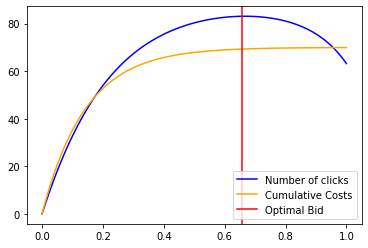

In [10]:
# advertising
n_bids = 100
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_bids)
sigma_clicks = 3
sigma_costs = 3
def clicks(x):
  return 100 * (1.0 - np.exp(-4*x+3*x**3))
def costs(x):
  return 70 * (1.0 - np.exp(-7*x))

opt_reward = opt_rate*prices[np.argmax(p*prices)]*clicks(bids)-costs(bids)
opt_bid = bids[np.argmax(opt_reward)]
fig, ax = plt.subplots()
ax.plot(bids,clicks(bids),'blue',bids,costs(bids),'orange')
ax.axvline(opt_bid,c='red')
ax.legend(["Number of clicks", "Cumulative Costs", "Optimal Bid"])

print("Advertising (optimal bid):")
print("idx: " + str(np.argmax(opt_rate*prices[np.argmax(p*prices)]*clicks(bids)-costs(bids))) + "  bid: " + str(opt_bid) + "  clicks-costs: " + str(clicks(opt_bid)-costs(opt_bid)))

## Known advertising

In [15]:
# experiments
ts_rewards_per_experiment = []
ucb_rewards_per_experiment = []

for e in tqdm(range(0,10)):  # cycle on experiments
  env = Environment(n_arms = n_prices,
                    probabilities = p,
                    bids = bids,
                    average_number_of_clicks = clicks,
                    average_cum_daily_cost = costs,
                    noise_clicks = sigma_clicks,
                    noise_cost = sigma_costs)
  ts_learner = TS_Pricing_Learner(n_arms = n_prices,
                                       prices = prices)
  ucb_learner = UCB_Pricing_Learner(n_arms = n_prices,
                                    prices = prices)


  ts_collected_costs = np.array([])
  ucb_collected_costs = np.array([])
  ts_daily_pricing_reward = np.array([])
  ucb_daily_pricing_reward = np.array([])

  for t in range(0,T):  # cycle on time horizon
    
    pulled_bid = np.argmax(clicks(bids)-costs(bids))
    reward_click, reward_cost = env.bidding_round(pulled_bid)
    
    # TS
    ts_collected_costs = np.append(ts_collected_costs, reward_cost)
    for k in range(reward_click):
      pulled_price = ts_learner.pull_arm()
      reward_price = env.pricing_round(pulled_price)
      ts_learner.update(pulled_price, reward_price)
    ts_daily_pricing_reward = np.append(ts_daily_pricing_reward,np.sum(ts_learner.collected_rewards[-reward_click:]))
    

    # UCB
    ucb_collected_costs = np.append(ucb_collected_costs, reward_cost)
    for k in range(reward_click):
      pulled_price = ucb_learner.pull_arm()
      reward_price = env.pricing_round(pulled_price)
      ucb_learner.update(pulled_price, reward_price)
    ucb_daily_pricing_reward = np.append(ucb_daily_pricing_reward,np.sum(ucb_learner.collected_rewards[-reward_click:]))

  
  ts_rewards_per_experiment.append(ts_daily_pricing_reward - ts_collected_costs)
  ucb_rewards_per_experiment.append(ucb_daily_pricing_reward - ucb_collected_costs)

  0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

63 83 73.29802028636229
63 88 68.59540515403113
63 81 70.15101251247626
63 80 68.09395381778037
63 80 67.81457549130731
63 77 69.93016299814973
63 80 74.74884753545531
63 80 70.16457416318212
63 82 69.30875047362484
63 77 68.96868404461341
63 81 73.227017469391
63 81 72.40764909475017
63 85 62.32265406878763
63 83 67.97935885653786
63 81 64.38863502493028
63 83 71.19704648066707
63 80 67.2314725589155
63 83 72.07407374028885
63 83 66.68384162780421
63 81 67.87831261501452
63 82 68.12551635618404
63 82 74.86819609484873
63 77 66.50350533793969
63 83 72.3524179394659
63 85 73.94072520575136
63 86 69.70555725233784
63 83 68.19330117472182
63 85 69.61241964857048
63 85 71.67288757890638
63 81 70.66100606399385
63 84 68.95529556394256
63 79 70.4476507057745
63 78 71.91153485862655
63 82 68.83977685136048
63 81 73.25101285403332
63 80 66.25246224822209
63 84 68.6123408085541
63 83 62.334483815872
63 79 69.80712490598269
63 85 72.86048449984692
63 85 68.50455371608075
63 85 66.5901944691643
6

 10%|█████████████████▌                                                                                                                                                             | 1/10 [00:03<00:27,  3.02s/it]

63 84 70.23124108032093
63 79 68.52912420572257
63 81 65.35122182091978
63 83 68.09080929210553
63 84 73.78430591276648
63 86 77.94353620108133
63 81 67.75985782252194
63 87 69.37988236027067
63 79 63.65022396466878
63 81 73.50710715145881
63 83 69.46593536698856
63 89 71.60418621308979
63 84 69.67451366402686
63 84 71.68951287139951
63 87 64.17293880731162
63 85 78.91444920429042
63 85 66.09789770185046
63 81 66.38159949084293
63 80 69.39759391179126
63 79 66.88283298065146
63 91 74.91272131347971
63 84 62.959857778343654
63 83 65.92363255204513
63 83 66.11836283030466
63 82 68.27247546954919
63 75 71.23355122180394
63 76 69.85179003187386
63 85 69.31361508542821
63 84 73.11871437978486
63 81 66.21011663962906
63 82 66.09223428401685
63 87 64.72972158860547
63 83 70.34567139712993
63 82 69.86693562635581
63 84 68.23245637152259
63 84 71.30168522760603
63 83 64.39187790260226
63 80 65.98784540014022
63 88 71.47685636322383
63 81 67.54746518598994
63 80 67.69498445039925
63 83 71.769091

 20%|███████████████████████████████████                                                                                                                                            | 2/10 [00:05<00:22,  2.85s/it]

63 81 64.40860629543297
63 81 73.10987976160592
63 84 68.1711816914047
63 84 69.42043088094928
63 81 67.03226884235045
63 81 70.13688360776436
63 82 73.10628133426171
63 82 69.80841526957552
63 78 69.778129094867
63 74 71.8316175702518
63 86 68.00578352176083
63 84 67.49159676436504
63 84 75.6626737309752
63 81 68.29574114020426
63 82 66.25831351436163
63 80 71.31737394301783
63 87 69.34752715377913
63 81 70.48662052169252
63 78 67.07893841373074
63 83 63.61987265053075
63 82 75.52729476173997
63 85 69.95171092059722
63 81 65.17709466807979
63 83 71.79490354023147
63 80 74.18874083194946
63 79 64.51297310179824
63 80 75.00390612650355
63 86 68.3220774712198
63 79 72.3722225020041
63 83 74.00549850180319
63 81 68.13823014507855
63 85 73.69660951464594
63 82 64.01757369888426
63 83 67.98074068443962
63 82 69.84735909141374
63 79 70.10891500151389
63 85 71.30242471053013
63 82 76.6596051924119
63 85 69.40988863924066
63 86 66.72679442076354
63 85 70.65250742322571
63 85 70.31365988878177


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 3/10 [00:08<00:19,  2.78s/it]

63 80 70.32148973676071
63 79 67.58347337246997
63 84 66.48001238633695
63 89 73.19812898058127
63 90 70.73955227354956
63 80 70.41908011781241
63 81 68.61398631342621
63 80 67.44444265830117
63 79 71.47501685953722
63 81 65.85161985788463
63 81 72.19143149302342
63 80 67.63499599445784
63 81 70.99240135495677
63 85 72.89685428674025
63 85 68.47743805197396
63 87 73.81624507239282
63 83 68.36569949016403
63 83 70.19827482709704
63 83 73.77289767210348
63 82 65.02595644990961
63 86 76.13816011918189
63 78 73.76620021110631
63 81 69.60292954978107
63 78 67.50031410101916
63 87 73.53844671381286
63 81 68.42459152464411
63 86 71.7931654993621
63 82 76.16644355950187
63 82 71.3168278423453
63 82 71.01905648798008
63 82 75.75416120821347
63 85 68.57150067670871
63 83 67.96645648166525
63 84 65.50002534601796
63 82 67.44035527891971
63 83 66.05826317663772
63 80 66.35286542903964
63 80 69.92138045089598
63 82 69.59145031942622
63 85 66.19256265882035
63 82 68.0787297456628
63 81 64.7827193295

 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 4/10 [00:11<00:16,  2.74s/it]

63 81 67.86817904067497
63 87 69.20415663977352
63 80 64.75167406807907
63 84 68.18886774025303
63 84 69.8626692702034
63 86 69.91060915039189
63 85 70.34060734435667
63 79 65.43632199157747
63 84 67.1650060295989
63 85 70.3156037958001
63 85 72.69358614518175
63 84 71.13215065556757
63 81 72.45672660760678
63 81 69.70304023625295
63 76 65.34671506689335
63 86 66.4304664769206
63 82 72.75746705809512
63 87 72.69547427619139
63 79 73.59331987226886
63 84 69.71510219286219
63 83 67.4259587992639
63 82 75.87654631669264
63 78 62.99634103314657
63 85 68.54881001848662
63 78 68.96766430430722
63 81 69.36884658517238
63 82 69.2602380419722
63 84 64.77809990810624
63 83 67.0852712634477
63 81 69.40787953364539
63 86 71.33377860904154
63 79 66.20170933229831
63 85 68.16721494332506
63 81 68.81176002355026
63 81 67.02272147686779
63 81 62.38337738333104
63 86 70.40413408955862
63 82 68.08842887830762
63 82 66.21211679845658
63 79 72.14426199245426
63 79 66.59831610316539
63 88 71.7164401699674


 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:14<00:14,  2.81s/it]

63 80 67.93146748241281
63 84 70.69059116957
63 83 72.60922530023045
63 80 69.83746215562107
63 81 68.42698605514049
63 86 75.43497037851104
63 81 63.73165707709917
63 85 74.05253610198027
63 81 71.65281019659105
63 87 71.36257805332927
63 83 72.5123319064337
63 86 67.25106101652563
63 83 71.11120187046868
63 87 72.60408555768419
63 84 69.63418852059075
63 78 67.08480080636076
63 81 65.21544148320262
63 83 69.44089086425299
63 82 68.33960327888475
63 87 62.54085968704919
63 78 70.12341806694667
63 84 65.04376746599704
63 82 70.67739638815857
63 86 68.5637136215056
63 86 70.49434844478475
63 80 66.62150380536785
63 88 70.08980453305178
63 83 71.15448471215304
63 83 69.59474816222836
63 79 68.89258435637049
63 78 67.67971521898414
63 81 69.74774092723933
63 81 65.81662552002575
63 79 64.77021547193095
63 80 66.34631846925653
63 85 69.15881863585346
63 87 68.66447260655171
63 80 68.91351991901116
63 87 68.21987184298303
63 86 64.90246884494805
63 85 73.65721273761811
63 80 68.950985905419

 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 5/10 [00:15<00:15,  3.02s/it]

63 80 65.26069332034105
63 83 68.26614868833981
63 78 70.91390027335319
63 81 68.43743754626063
63 82 66.41293919547239
63 80 68.13148025952864
63 79 67.91716642144674
63 85 75.12570759702325
63 78 64.91693809658065
63 83 69.8959431011025
63 82 69.95331482821646
63 80 68.9793241931351
63 83 70.37859134729409
63 85 66.72009861430315
63 81 64.32439100780293
63 83 71.14155180713581
63 82 66.48624943316995
63 84 70.75010866700325
63 85 63.60819953812604
63 83 65.77415179631693
63 88 73.1060723339571
63 85 66.43646088409619
63 85 71.33698177458619
63 79 72.91546143826982
63 91 70.16585002079552


KeyboardInterrupt: 

In [14]:
reward_click, reward_cost

(86, 70.95925618984143)

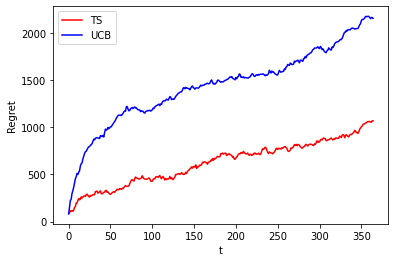

In [12]:
opt = opt_rate*prices[np.argmax(p*prices)]*clicks(opt_bid) - costs(opt_bid)
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis = 0)), 'b')
plt.legend(["TS", "UCB"])